In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.datasets import make_blobs, make_moons, make_classification
from sklearn.datasets import load_breast_cancer

In [4]:
class AdaBoosting:
    def __init__(self,
                 n_estimators: int,
                 **kwargs,
                ):
        self.n_estimators = n_estimators
        self.w = None
        self.estimators = None
        self.alpha = None
        self.losses = None
        self.kwargs = kwargs
        
    def fit(self, X, y):
        if np.abs(y).all() != 1:
            y = 2 * y - 1
            
        self.w = np.ones(len(y))
        self.w /= len(y)
        
        self.estimators = []
        self.alpha = []
        self.losses = []
            
        for i in range(self.n_estimators):
            estimator = DecisionTreeClassifier(
                **self.kwargs
            ).fit(
                X, 
                y,
                sample_weight=self.w,
            )
            y_pred = estimator.predict(X)
            loss = self.evaluete_loss(X, y, y_pred)
            loss = np.clip(loss, 1e-8, 1-1e-8)
            alpha = np.log((1-loss)/loss)/2
            self.alpha.append(alpha)
            self.estimators.append(estimator)
            
            self.w = self.w * np.exp(
                alpha * (-y*y_pred)
#                 alpha * self.indicator(y, y_pred) # alternative
            ) / np.sum(
                self.w * np.exp(alpha * (-y*y_pred))
#                 self.w * np.exp(alpha * self.indicator(y, y_pred)) # alternative
            )
            
            self.losses.append(self.exploss(X, y))
            
    def evaluete_loss(self, X, y, y_pred):
        loss = np.sum(self.w * self.indicator(y, y_pred)) / np.sum(self.w)
        return loss
    
    def exploss(self, X, y):
        return np.sum(self.w * np.exp(-y * self.predict(X)))
    
    def indicator(self, y, y_pred):
        return (y != y_pred).astype(int)
    
    def predict(self, X):
        result = np.zeros(len(X))
        for i, estimator in enumerate(self.estimators):
            result += self.alpha[i] * estimator.predict(X)
            
        return np.sign(result)
    
    def predict_proba(self, X):
        result = np.zeros(len(X))
        for i, estimator in enumerate(self.estimators):
            result += self.alpha[i] * estimator.predict(X)
            
        return 1 / (1 + np.exp(-result))

In [5]:
def plot_mesh_grid(clf, datasets):
    
    i = 1
    plt.figure(figsize=(18,7))
    for ds in datasets:
        plt.subplot(1, len(datasets), i)
    
        eps = 0.3
        
        clf.fit(ds[0], ds[1]*2 - 1)

        xx, yy = np.meshgrid(np.linspace(np.min(ds[0][:,0]) - eps, np.max(ds[0][:,0]) + eps, 200),
                             np.linspace(np.min(ds[0][:,1]) - eps, np.max(ds[0][:,1]) + eps, 200))
        
        try:
            z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()][:, :])[:, 1].reshape(xx.shape)
        except:
            z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)

        plt.pcolormesh(xx, yy, z, cmap='RdYlBu', shading='auto')
        plt.scatter(ds[0][:, 0], ds[0][:, 1], c=ds[1], cmap='Set1', edgecolors='black')
        
        plt.title(f'Accuracy: {accuracy_score(ds[1]*2 - 1, clf.predict(ds[0])).round(2)}')
        
        i+=1

# Test Datasets

In [6]:
datasets = (
        make_moons(300, noise=0.2, random_state=42),
        make_blobs(n_samples=300, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=42),
        make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0)
    )

In [7]:
ada_boost = AdaBoosting(
    n_estimators=100,
    random_state=42,
    max_depth=1,
)

In [8]:
sk_ada_boost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42, max_depth=1),
    n_estimators=100,
)

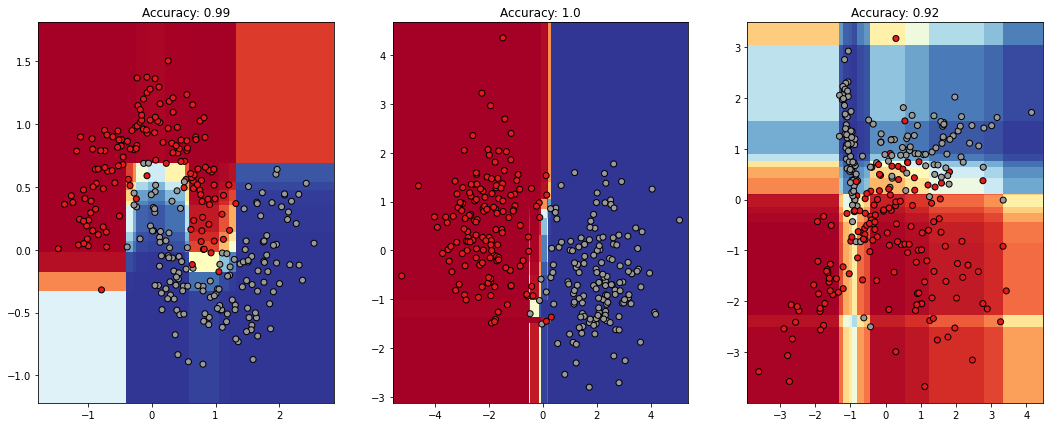

In [9]:
plot_mesh_grid(ada_boost, datasets)

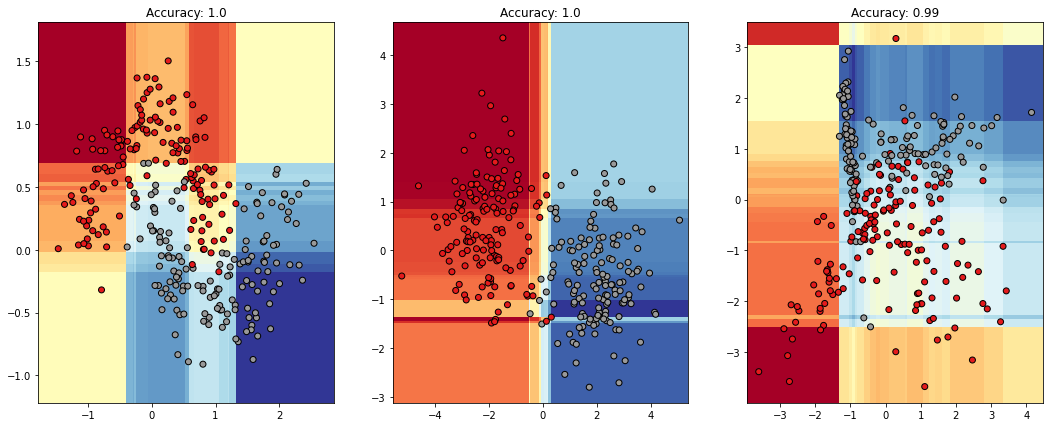

In [10]:
plot_mesh_grid(sk_ada_boost, datasets)

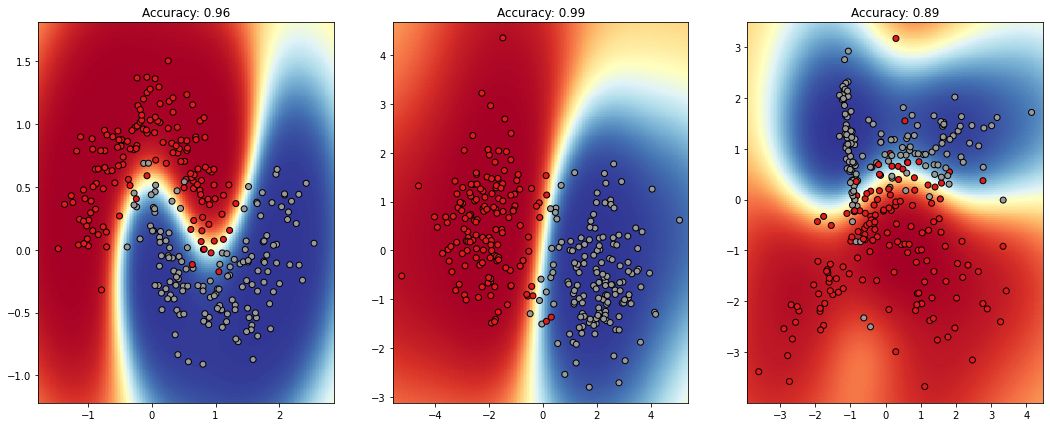

In [11]:
plot_mesh_grid(SVC(probability=True), datasets)

# Breast Cancer

In [12]:
x = load_breast_cancer().data
y = load_breast_cancer().target

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=42,
    test_size=0.3,
)

In [14]:
ada_boost = AdaBoosting(
    n_estimators=50,
    max_depth=1,
    random_state=42,
)

In [15]:
ada_boost.fit(x_train, y_train)

In [16]:
accuracy_score(y_test*2-1, ada_boost.predict(x_test))

0.9707602339181286

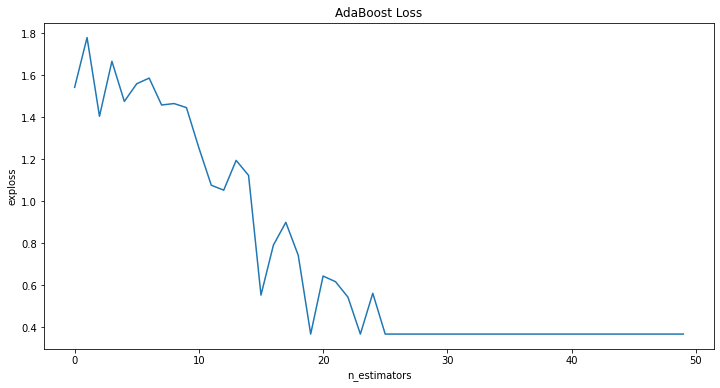

In [17]:
plt.figure(figsize=(12,6))
plt.plot(ada_boost.losses)
plt.title('AdaBoost Loss')
plt.ylabel('exploss')
plt.xlabel('n_estimators')
plt.show()